<a href="https://colab.research.google.com/github/cindylay/cs159-final-proj/blob/main/text_classification__comaprison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras import *
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from plotly import graph_objs as go
from sklearn.metrics import classification_report, plot_confusion_matrix
import random
import numpy as np
import seaborn as sns

In [2]:
import csv
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/CS159/BERT_DATA_DIR/train.csv' train.csv
!cp '/content/drive/MyDrive/CS159/BERT_DATA_DIR/valid.csv' valid.csv
train_df = pd.read_csv('train.csv', encoding='utf-8')
valid_df = pd.read_csv('valid.csv', encoding='utf-8')
concat_data = pd.concat((train_df, valid_df))

Mounted at /content/drive


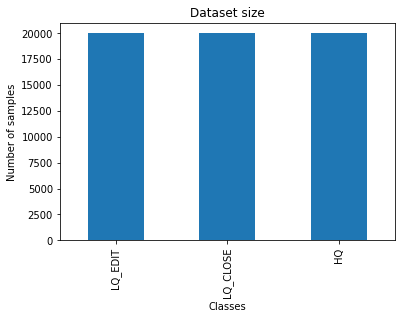

In [3]:
concat_data.Y.value_counts().plot.bar()
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Dataset size')
plt.show()

In [4]:
concat_data['Text']=concat_data.Body.apply(lambda x: BeautifulSoup(x, 'html.parser').text)
concat_data.head()

,Id,Title,Body,Tags,CreationDate,Y,Text
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,I'm already familiar with repeating tasks ever...
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,I'd like to understand why Java 8 Optionals we...
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,I am attempting to overlay a title over an ima...
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,"The question is very simple, but I just could ..."
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,I'm using custom floatingactionmenu. I need to...


In [5]:
HQ = concat_data[concat_data['Y']=='HQ']['Text'].str.split().map(lambda x: len(x) if len(x) < 500 else 500)
LQ_EDIT = concat_data[concat_data['Y']=='LQ_EDIT']['Text'].str.split().map(lambda x: len(x) if len(x) < 500 else 500)
LQ_CLOSE = concat_data[concat_data['Y']=='LQ_CLOSE']['Text'].str.split().map(lambda x: len(x) if len(x) < 500 else 500)

fig = go.Figure()
fig.add_trace(go.Histogram(x=HQ, histfunc='avg', name="HQ", opacity=0.6, histnorm='probability density'))
fig.add_trace(go.Histogram(x=LQ_EDIT, histfunc='avg', name="LQ_EDIT", opacity=0.6, histnorm='probability density'))
fig.add_trace(go.Histogram(x=LQ_CLOSE, histfunc='avg', name="LQ_CLOSE", opacity=0.6, histnorm='probability density'))

fig.update_layout(
    title_text='Question word count frequency',
    xaxis_title_text='Word count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.1,
    barmode='overlay'
)
fig.show()

In [6]:
train, remain = train_test_split(concat_data, test_size=0.2, random_state=0)
validation, test = train_test_split(remain, test_size=0.5, random_state=0)

print(f'The size of training dataset is: {len(train)} samples')
print(f'The size of validation dataset is: {len(validation)} samples')
print(f'The size of test dataset is: {len(test)} samples')

The size of training dataset is: 48000 samples
The size of validation dataset is: 6000 samples
The size of test dataset is: 6000 samples


In [7]:
encoder = LabelEncoder()
encoder.fit(concat_data.Y.values)

encoded_train_Y = encoder.transform(train.Y.values)
encoded_valid_Y = encoder.transform(validation.Y.values)
encoded_test_Y = encoder.transform(test.Y.values)

train_X = train.Text.values
valid_X = validation.Text.values
test_X = test.Text.values

train_Y = np_utils.to_categorical(encoded_train_Y)
valid_Y = np_utils.to_categorical(encoded_valid_Y)
test_Y = np_utils.to_categorical(encoded_test_Y)

In [8]:
SEQ_LEN = 360
VOCAB_SIZE = 100000
EPOCHS = 25
BATCH_SIZE = 32
OOV_TOKEN = '<UNK>'

tokens = preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokens.fit_on_texts(list(train_X))

train_X = tokens.texts_to_sequences(train_X)
valid_X = tokens.texts_to_sequences(valid_X)
test_X = tokens.texts_to_sequences(test_X)

print(np.quantile([len(x) for x in train_X], 0.95))

train_X = preprocessing.sequence.pad_sequences(train_X, maxlen=SEQ_LEN, padding='post', truncating='post')
valid_X = preprocessing.sequence.pad_sequences(valid_X, maxlen=SEQ_LEN, padding='post', truncating='post')
test_X = preprocessing.sequence.pad_sequences(test_X, maxlen=SEQ_LEN, padding='post', truncating='post')

340.0


In [9]:
inputs = Input(shape=(None,), dtype="int32")

x = layers.Embedding(VOCAB_SIZE, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(3, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=1e-4), 
              metrics=['accuracy'],)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         12800000  
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 12,998,019
Trainable params: 12,998,019
Non-tra

In [10]:
my_callbacks = [callbacks.ModelCheckpoint('lstm.h5', monitor='val_loss', save_best_only=True, verbose=2),
                callbacks.EarlyStopping(monitor='val_loss',  patience=5, verbose=2),
                callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2)]

lstm = model.fit(train_X, 
                train_Y, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                validation_data=(valid_X, valid_Y),
                callbacks = my_callbacks, 
                verbose=1)

Epoch 1/25
1500/1500 [==============================] - ETA: 0s - loss: 0.5285 - accuracy: 0.5436
Epoch 00001: val_loss improved from inf to 0.47394, saving model to lstm.h5
1500/1500 [==============================] - 116s 70ms/step - loss: 0.5285 - accuracy: 0.5436 - val_loss: 0.4739 - val_accuracy: 0.6190 - lr: 1.0000e-04
Epoch 2/25
1500/1500 [==============================] - ETA: 0s - loss: 0.4330 - accuracy: 0.6631
Epoch 00002: val_loss improved from 0.47394 to 0.46351, saving model to lstm.h5
1500/1500 [==============================] - 104s 69ms/step - loss: 0.4330 - accuracy: 0.6631 - val_loss: 0.4635 - val_accuracy: 0.6410 - lr: 1.0000e-04
Epoch 3/25
1500/1500 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.7264
Epoch 00003: val_loss did not improve from 0.46351
1500/1500 [==============================] - 103s 69ms/step - loss: 0.3783 - accuracy: 0.7264 - val_loss: 0.4642 - val_accuracy: 0.6540 - lr: 1.0000e-04
Epoch 4/25
1500/1500 [==================

In [11]:
loss, accuracy = model.evaluate(test_X, test_Y)

pred_Y = model.predict(test_X)
pred_Y = np.argmax(pred_Y, axis=1)

true_Y = np.argmax(test_Y, axis=1)

CLASSES = list(encoder.classes_)
print(classification_report(true_Y, pred_Y, target_names=CLASSES))

188/188 [==============================] - 8s 41ms/step - loss: 0.5643 - accuracy: 0.6588
              precision    recall  f1-score   support

          HQ       0.80      0.77      0.79      1981
    LQ_CLOSE       0.54      0.61      0.58      1996
     LQ_EDIT       0.65      0.59      0.62      2023

    accuracy                           0.66      6000
   macro avg       0.67      0.66      0.66      6000
weighted avg       0.67      0.66      0.66      6000



In [12]:
def visualize_confusion_matrix(accuracy, labels, val_pred_labels, val_true_labels):
    '''
    Plots the confusion matrix for given data.
    '''
    confusion_matrix = np.zeros((3, 3), dtype=np.int16)
    for pred, true in zip(val_pred_labels, val_true_labels):
        confusion_matrix[pred, true] += 1
    confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1,keepdims=1)
    
    plt.figure(figsize=(20, 20))
    sns.set(font_scale=1.5)
    ax = sns.heatmap(confusion_matrix, annot=True, square=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
    ax.set_title(f'Confusion Matrix (Accuracy = {accuracy})', fontsize=50)
    ax.set_xticklabels(labels, fontsize=15)
    ax.set_yticklabels(labels, fontsize=15)
    ax.set_xlabel("True Label", fontsize=25)
    ax.set_ylabel("Predicted Label", fontsize=25)
    plt.show()

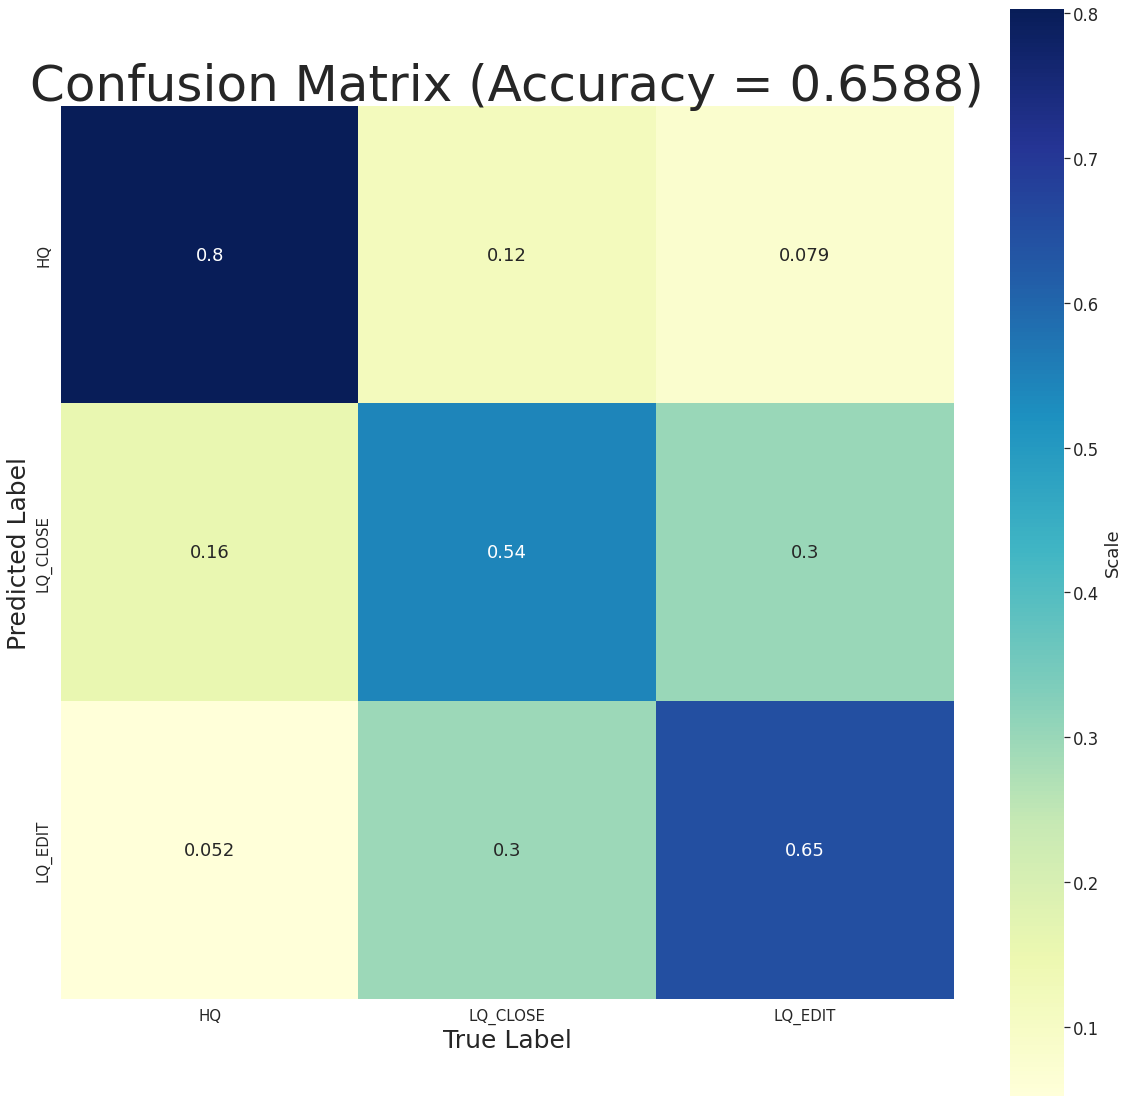

In [13]:
visualize_confusion_matrix(round(accuracy, 4), CLASSES, pred_Y, true_Y)

In [14]:
inputs = Input(shape=(SEQ_LEN,), dtype="int32")

x = layers.Embedding(VOCAB_SIZE, 128)(inputs)
x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

outputs = layers.Dense(3, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4), 
              metrics=['accuracy'],)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 360)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 360, 128)          12800000  
                                                                 
 conv1d (Conv1D)             (None, 360, 32)           12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 180, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5760)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               737408    
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [15]:
my_callbacks = [callbacks.ModelCheckpoint('cnn.h5', monitor='val_loss', save_best_only=True, verbose=2),
                callbacks.EarlyStopping(monitor='val_loss',  patience=5, verbose=2),
                callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2)]

cnn = model.fit(train_X, 
                train_Y, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                validation_data=(valid_X, valid_Y),
                callbacks = my_callbacks, 
                verbose=1)

Epoch 1/25
1497/1500 [============================>.] - ETA: 0s - loss: 0.5319 - accuracy: 0.5431
Epoch 00001: val_loss improved from inf to 0.47128, saving model to cnn.h5
1500/1500 [==============================] - 22s 10ms/step - loss: 0.5317 - accuracy: 0.5433 - val_loss: 0.4713 - val_accuracy: 0.6228 - lr: 1.0000e-04
Epoch 2/25
1495/1500 [============================>.] - ETA: 0s - loss: 0.4206 - accuracy: 0.6819
Epoch 00002: val_loss improved from 0.47128 to 0.44112, saving model to cnn.h5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.4206 - accuracy: 0.6819 - val_loss: 0.4411 - val_accuracy: 0.6648 - lr: 1.0000e-04
Epoch 3/25
1499/1500 [============================>.] - ETA: 0s - loss: 0.3529 - accuracy: 0.7515
Epoch 00003: val_loss did not improve from 0.44112
1500/1500 [==============================] - 11s 7ms/step - loss: 0.3529 - accuracy: 0.7515 - val_loss: 0.4539 - val_accuracy: 0.6635 - lr: 1.0000e-04
Epoch 4/25
1499/1500 [=========================

In [16]:
loss, accuracy = model.evaluate(test_X, test_Y)

pred_Y = model.predict(test_X)
pred_Y = np.argmax(pred_Y, axis=1)

true_Y = np.argmax(test_Y, axis=1)

CLASSES = list(encoder.classes_)
print(classification_report(true_Y, pred_Y, target_names=CLASSES))

188/188 [==============================] - 0s 2ms/step - loss: 0.5337 - accuracy: 0.6680
              precision    recall  f1-score   support

          HQ       0.79      0.81      0.80      1981
    LQ_CLOSE       0.58      0.61      0.59      1996
     LQ_EDIT       0.64      0.58      0.61      2023

    accuracy                           0.67      6000
   macro avg       0.67      0.67      0.67      6000
weighted avg       0.67      0.67      0.67      6000



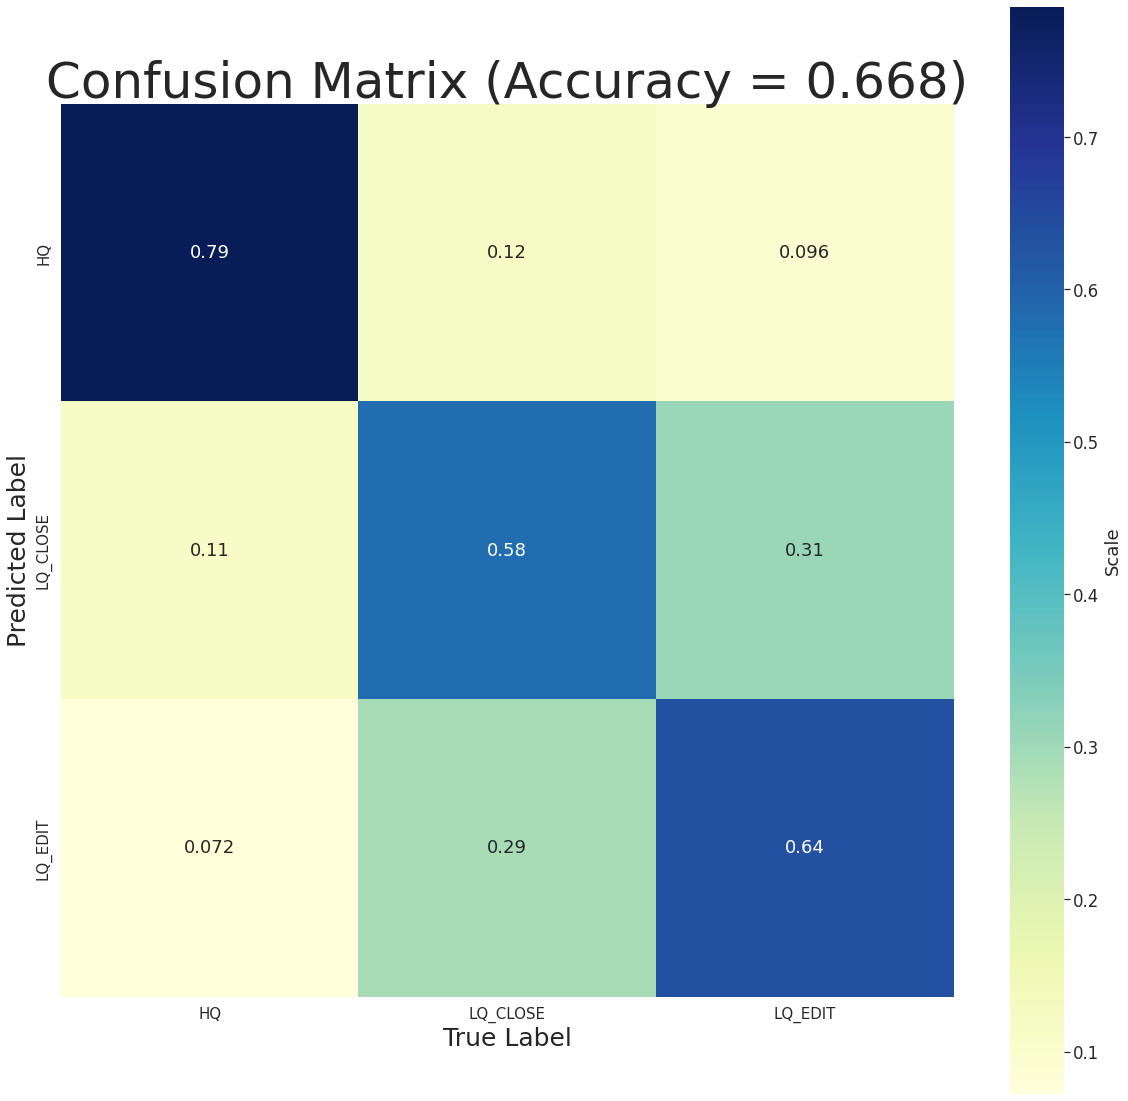

In [17]:
visualize_confusion_matrix(round(accuracy, 4), CLASSES, pred_Y, true_Y)


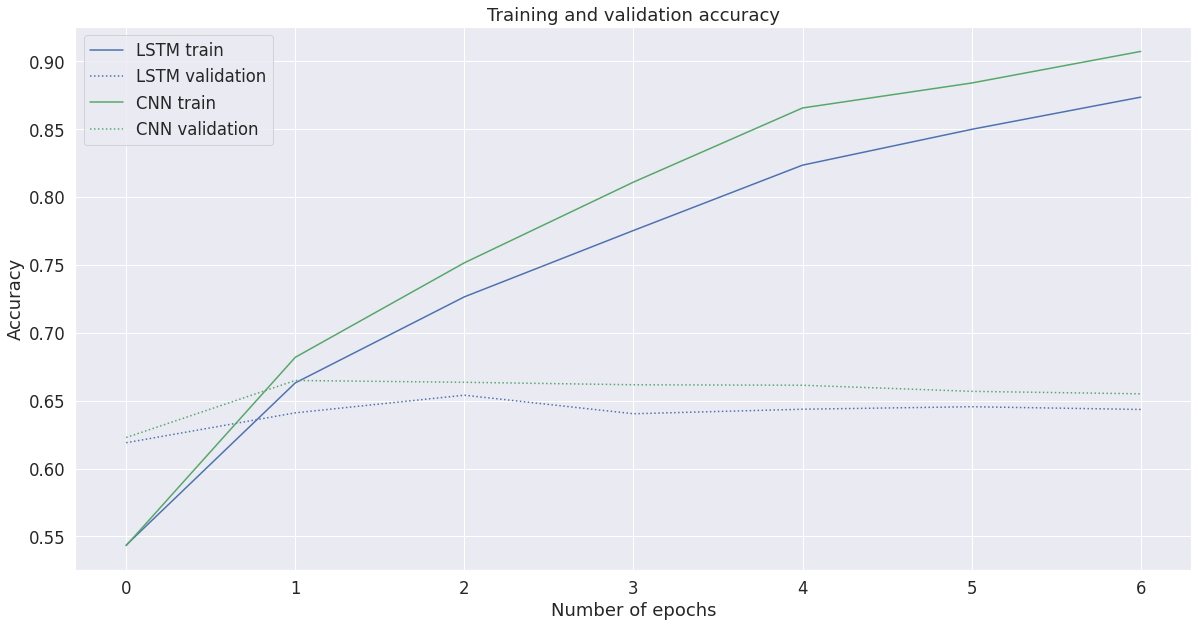

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(lstm.history['accuracy'], label='LSTM train', linestyle='-', color='b')
plt.plot(lstm.history['val_accuracy'], label='LSTM validation', linestyle=':', color='b')
plt.plot(cnn.history['accuracy'], label='CNN train', linestyle='-', color='g')
plt.plot(cnn.history['val_accuracy'], label='CNN validation', linestyle=':', color='g')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

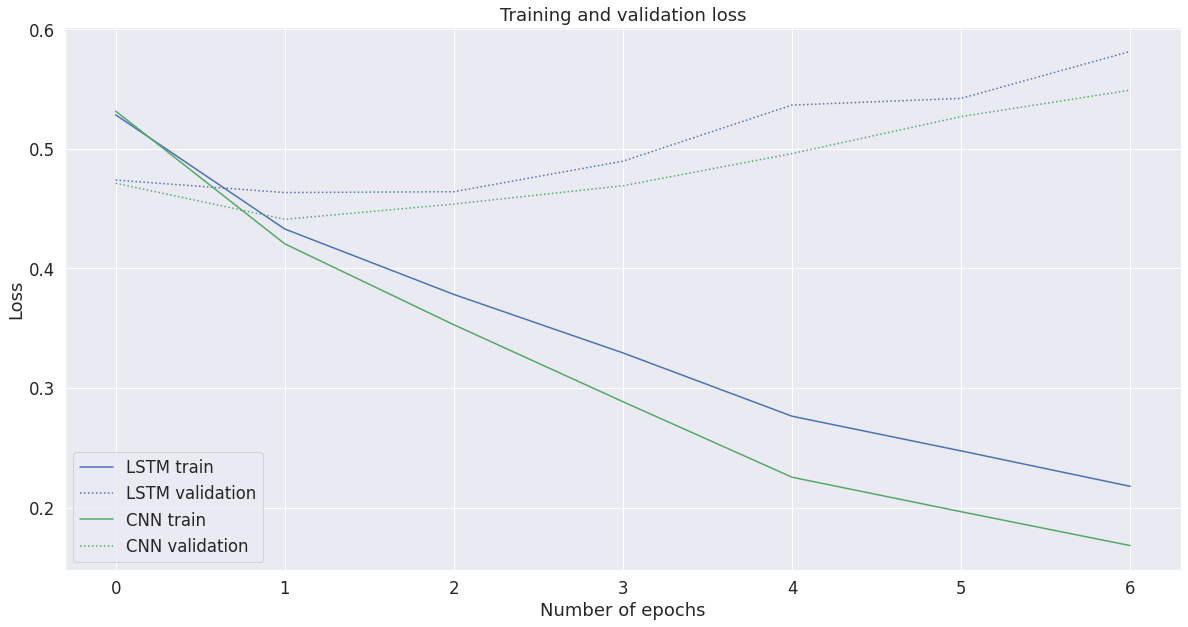

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(lstm.history['loss'], label='LSTM train', linestyle='-', color='b')
plt.plot(lstm.history['val_loss'], label='LSTM validation', linestyle=':', color='b')
plt.plot(cnn.history['loss'], label='CNN train', linestyle='-', color='g')
plt.plot(cnn.history['val_loss'], label='CNN validation', linestyle=':', color='g')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()